<a href="https://www.kaggle.com/code/shariful07/tps-oct-2022-eda-and-ensemble-hybrid-model?scriptVersionId=109885447" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# TPS OCT 2022

**The goal of the competition is to predict -- from a given snapshot in the game -- for each team, the probability that they will score within the next 10 seconds of game time.**

**If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)**

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.special import softmax
from cycler import cycler
from IPython.display import display
import datetime
import joblib
import gc
from pathlib import Path
from fastai.tabular.all import *
import fastai.losses as loss

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('display.max_columns', None)   

/kaggle/input/tabular-playground-series-oct-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-oct-2022/train_9.csv
/kaggle/input/tabular-playground-series-oct-2022/train_3.csv
/kaggle/input/tabular-playground-series-oct-2022/train_4.csv
/kaggle/input/tabular-playground-series-oct-2022/test_dtypes.csv
/kaggle/input/tabular-playground-series-oct-2022/train_8.csv
/kaggle/input/tabular-playground-series-oct-2022/train_dtypes.csv
/kaggle/input/tabular-playground-series-oct-2022/train_5.csv
/kaggle/input/tabular-playground-series-oct-2022/train_2.csv
/kaggle/input/tabular-playground-series-oct-2022/test.csv
/kaggle/input/tabular-playground-series-oct-2022/train_0.csv
/kaggle/input/tabular-playground-series-oct-2022/train_7.csv
/kaggle/input/tabular-playground-series-oct-2022/train_1.csv
/kaggle/input/tabular-playground-series-oct-2022/train_6.csv
/kaggle/input/tps-2022-10-fastai-with-multistart-and-tta/model_fastai_multistart_tta.csv
/kaggle/input/tps-2022-10-fastai-with-mul

**Let's start by reading the data and looking at the first few rows:**

In [2]:
df = pd.read_csv("/kaggle/input/tabular-playground-series-oct-2022/train_0.csv")

In [3]:
print()
print('df')
display(df.head())


df


,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,p0_pos_y,p0_pos_z,p0_vel_x,p0_vel_y,p0_vel_z,p0_boost,p1_pos_x,p1_pos_y,p1_pos_z,p1_vel_x,p1_vel_y,p1_vel_z,p1_boost,p2_pos_x,p2_pos_y,p2_pos_z,p2_vel_x,p2_vel_y,p2_vel_z,p2_boost,p3_pos_x,p3_pos_y,p3_pos_z,p3_vel_x,p3_vel_y,p3_vel_z,p3_boost,p4_pos_x,p4_pos_y,p4_pos_z,p4_vel_x,p4_vel_y,p4_vel_z,p4_boost,p5_pos_x,p5_pos_y,p5_pos_z,p5_vel_x,p5_vel_y,p5_vel_z,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,1,1002,-33.313030,-0.0,0.0,1.8548,-0.0,0.0,0.0,41.8048,-51.925000,0.3402,5.635400,-4.8490,0.0042,33.34,-5.0654,-75.5194,0.3402,0.3602,9.960600,0.0000,27.33,-39.6544,-49.894398,0.3402,8.8092,8.809400,0.0000,22.34,5.0604,75.532005,0.3402,-0.5236,-8.050600,0.0042,33.34,-41.766403,52.006400,0.3410,-5.437600,5.437800,0.0052,33.34,39.757400,49.821600,0.3402,-8.2276,-9.275200,-0.0002,22.34,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
1,1,1002,-33.206146,-0.0,0.0,1.8548,-0.0,0.0,0.0,42.2616,-52.451202,0.3402,5.287199,-7.4774,0.0042,33.34,-4.9298,-74.3264,0.4900,2.2634,13.568199,6.0700,23.84,-38.6262,-48.871803,0.3402,11.6062,11.244201,0.0000,30.62,5.0110,74.772995,0.3402,-0.6998,-9.942000,0.0042,33.34,-42.407204,52.622402,0.5944,-7.172400,6.739800,6.2394,33.34,38.781400,48.761402,0.3402,-11.3378,-11.244000,0.0002,30.62,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
2,1,1002,-33.098114,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.2270,-54.054000,1.1466,5.686000,-9.7462,6.5052,33.34,-4.6880,-72.9590,1.0820,2.7758,15.537000,6.3438,23.14,-36.3452,-47.016200,1.1346,16.1252,12.458199,6.2390,26.89,4.9168,73.767600,0.3402,-1.1922,-11.803600,0.0042,33.34,-43.778200,54.081400,1.6450,-12.416600,15.706600,6.0082,33.34,36.503998,46.920600,1.0214,-16.3572,-12.203199,6.2126,26.89,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
3,1,1002,-32.993190,-0.0,0.0,1.8548,-0.0,0.0,0.0,43.8984,-55.225600,1.5936,10.595600,-18.5704,5.5184,33.34,-3.8408,-69.1258,1.9106,5.6770,25.291800,4.2014,23.14,-35.1736,-45.288000,1.5598,15.8896,26.249199,5.1802,23.38,4.6906,71.631400,0.4394,-1.7122,-15.544201,5.9916,31.00,-44.919800,55.525200,2.1334,-12.483199,15.779799,4.7494,33.34,35.151800,44.873398,1.5286,-14.6028,-26.306002,4.9346,23.38,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0
4,1,1002,-32.887756,-0.0,0.0,1.8548,-0.0,0.0,0.0,44.9606,-57.087800,2.0720,10.632600,-18.6378,4.1670,33.34,-3.2720,-66.5944,1.9814,5.6902,25.318401,-0.3020,23.14,-34.0660,-43.518997,1.8632,17.1810,26.739600,4.0358,19.84,4.5010,69.921600,1.0822,-2.0104,-18.120400,6.3364,27.47,-46.170400,57.104400,2.2552,-12.518800,15.799200,-0.2730,33.34,33.584800,42.203400,1.9106,-16.5764,-27.024800,1.3248,19.84,0.0,0.0,0.0,0.0,0.0,0.0,3,B,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149381 entries, 0 to 2149380
Data columns (total 61 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   game_num                     int64  
 1   event_id                     int64  
 2   event_time                   float64
 3   ball_pos_x                   float64
 4   ball_pos_y                   float64
 5   ball_pos_z                   float64
 6   ball_vel_x                   float64
 7   ball_vel_y                   float64
 8   ball_vel_z                   float64
 9   p0_pos_x                     float64
 10  p0_pos_y                     float64
 11  p0_pos_z                     float64
 12  p0_vel_x                     float64
 13  p0_vel_y                     float64
 14  p0_vel_z                     float64
 15  p0_boost                     float64
 16  p1_pos_x                     float64
 17  p1_pos_y                     float64
 18  p1_pos_z                     float64
 19  

<AxesSubplot:>

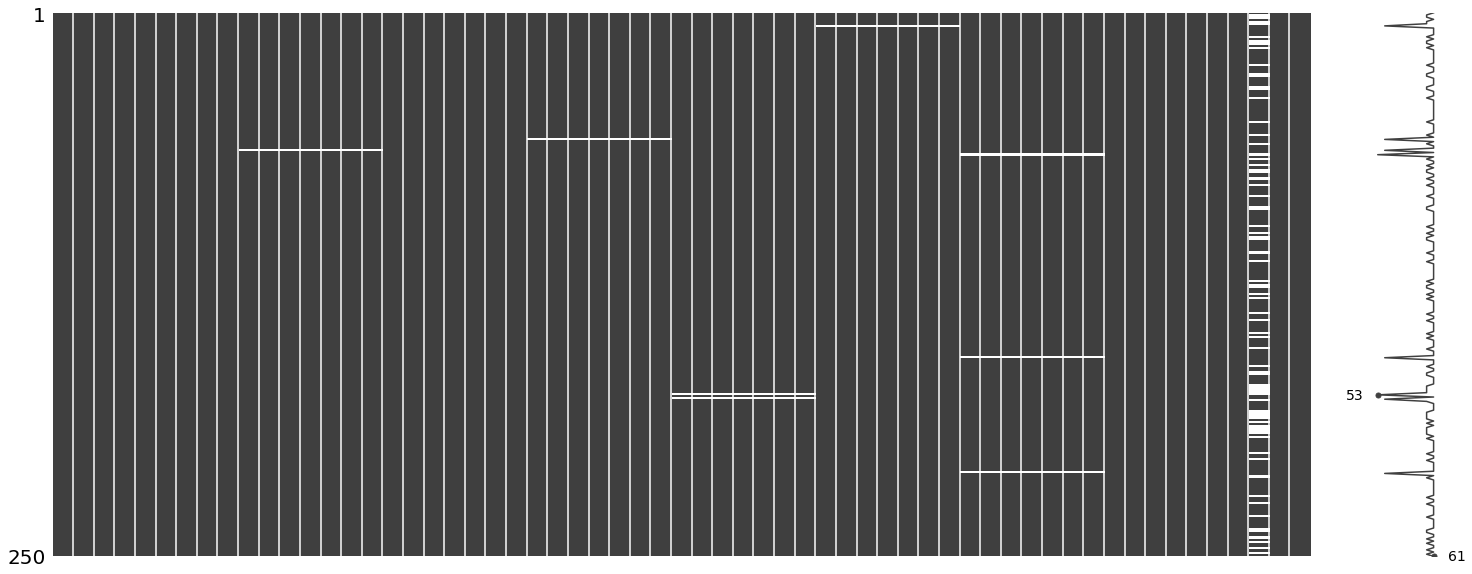

In [5]:
import missingno as msno
%matplotlib inline
msno.matrix(df.sample(250))

In [6]:
df.describe()

,game_num,event_id,event_time,ball_pos_x,ball_pos_y,ball_pos_z,ball_vel_x,ball_vel_y,ball_vel_z,p0_pos_x,p0_pos_y,p0_pos_z,p0_vel_x,p0_vel_y,p0_vel_z,p0_boost,p1_pos_x,p1_pos_y,p1_pos_z,p1_vel_x,p1_vel_y,p1_vel_z,p1_boost,p2_pos_x,p2_pos_y,p2_pos_z,p2_vel_x,p2_vel_y,p2_vel_z,p2_boost,p3_pos_x,p3_pos_y,p3_pos_z,p3_vel_x,p3_vel_y,p3_vel_z,p3_boost,p4_pos_x,p4_pos_y,p4_pos_z,p4_vel_x,p4_vel_y,p4_vel_z,p4_boost,p5_pos_x,p5_pos_y,p5_pos_z,p5_vel_x,p5_vel_y,p5_vel_z,p5_boost,boost0_timer,boost1_timer,boost2_timer,boost3_timer,boost4_timer,boost5_timer,player_scoring_next,team_A_scoring_within_10sec,team_B_scoring_within_10sec
count,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.130390e+06,2.130390e+06,2.130390e+06,2.130390e+06,2.130390e+06,2.130390e+06,2.130390e+06,2.130761e+06,2.130761e+06,2.130761e+06,2.130761e+06,2.130761e+06,2.130761e+06,2.130761e+06,2.129864e+06,2.129864e+06,2.129864e+06,2.129864e+06,2.129864e+06,2.129864e+06,2.129864e+06,2.129551e+06,2.129551e+06,2.129551e+06,2.129551e+06,2.129551e+06,2.129551e+06,2.129551e+06,2.130850e+06,2.130850e+06,2.130850e+06,2.130850e+06,2.130850e+06,2.130850e+06,2.130850e+06,2.130318e+06,2.130318e+06,2.130318e+06,2.130318e+06,2.130318e+06,2.130318e+06,2.130318e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06,2.149381e+06
mean,3.678573e+02,3.678601e+05,-6.615076e+01,-1.711843e-01,-8.701548e-03,1.566230e+01,-3.763223e-03,2.237860e-02,1.148253e-01,-8.151923e-02,-1.941015e+01,3.481090e+00,1.250747e-02,1.053601e+00,4.777011e-02,4.595350e+01,-3.635505e-01,-1.999821e+01,3.482017e+00,-1.238807e-02,1.046837e+00,5.177272e-02,4.605956e+01,-4.969748e-02,-1.968855e+01,3.477881e+00,1.572069e-02,1.065001e+00,5.082174e-02,4.605492e+01,-3.649735e-02,2.005645e+01,3.453079e+00,-2.541816e-03,-1.032868e+00,5.071225e-02,4.558186e+01,4.000194e-01,1.952145e+01,3.463677e+00,-4.216416e-03,-1.041858e+00,5.324023e-02,4.626961e+01,-1.090842e-01,1.939480e+01,3.472399e+00,-1.913268e-03,-1.009228e+00,4.875839e-02,4.577625e+01,-2.727069e+00,-2.754303e+00,-3.226214e+00,-3.220364e+00,-2.751841e+00,-2.718325e+00,1.604489e+00,5.831074e-02,5.575280e-02
std,2.125500e+02,2.125501e+05,6.682579e+01,4.909460e+01,6.008009e+01,1.044591e+01,2.316391e+01,2.806578e+01,1.228911e+01,4.550489e+01,5.856254e+01,6.496314e+00,2.106154e+01,2.429429e+01,6.281563e+00,3.409502e+01,4.556408e+01,5.846065e+01,6.494385e+00,2.102601e+01,2.432646e+01,6.300074e+00,3.395837e+01,4.559604e+01,5.839082e+01,6.500242e+00,2.103716e+01,2.431145e+01,6.322643e+00,3.400912e+01,4.532089e+01,5.823130e+01,6.476541e+00,2.098336e+01,2.422151e+01,6.279982e+00,3.392069e+01,4.561946e+01,5.840764e+01,6.460821e+00,2.103703e+01,2.430424e+01,6.276272e+00,3.404288e+01,4.569713e+01,5.839080e+01,6.499697e+00,2.108474e+01,2.429656e+01,6.314331e+00,3.410338e+01,3.301398e+00,3.306345e+00,3.364020e+00,3.363124e+00,3.306341e+00,3.300695e+00,2.080762e+00,2.343302e-01,2.294438e-01
min,1.000000e+00,1.002000e+03,-7.205285e+02,-8.079200e+01,-1.043092e+02,1.296000e+00,-9.920059e+01,-8.797200e+01,-6.299300e+01,-8.189000e+01,-1.198200e+02,2.640000e-02,-4.600000e+01,-4.600000e+01,-4.584820e+01,0.000000e+00,-8.189340e+01,-1.198002e+02,3.820000e-02,-4.600000e+01,-4.599980e+01,-4.586900e+01,0.000000e+00,-8.189540e+01,-1.197880e+02,2.820000e-02,-4.599980e+01,-4.600000e+01,-4.598780e+01,0.000000e+00,-8.191760e+01,-1.198110e+02,3.200000e-03,-4.599980e+01,-4.599980e+01,-4.471800e+01,0.000000e+00,-8.192720e+01,-1.197838e+02,4.740000e-02,-4.600000e+01,-4.599980e+01,-4.556300e+01,0.000000e+00,-8.190660e+01,-1.197722e+02,2.780000e-02,-4.599980e+01,-4.599980e+01,-4.532840e+01,0.000000e+00,-9.984000e+00,-9.984000e+00,-9.970000e+00,-9.984000e+00,-9.970000e+00,-9.970000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,1.830000e+02,1.830040e+05,-9.148513e+01,-4.498640e+01,-5.354000e+01,6.395000e+00,-1.558660e+01,-2.184260e+01,-7.648400e+00,-3.730970e+01,-7.210580e+01,3.402000e-

<AxesSubplot:>

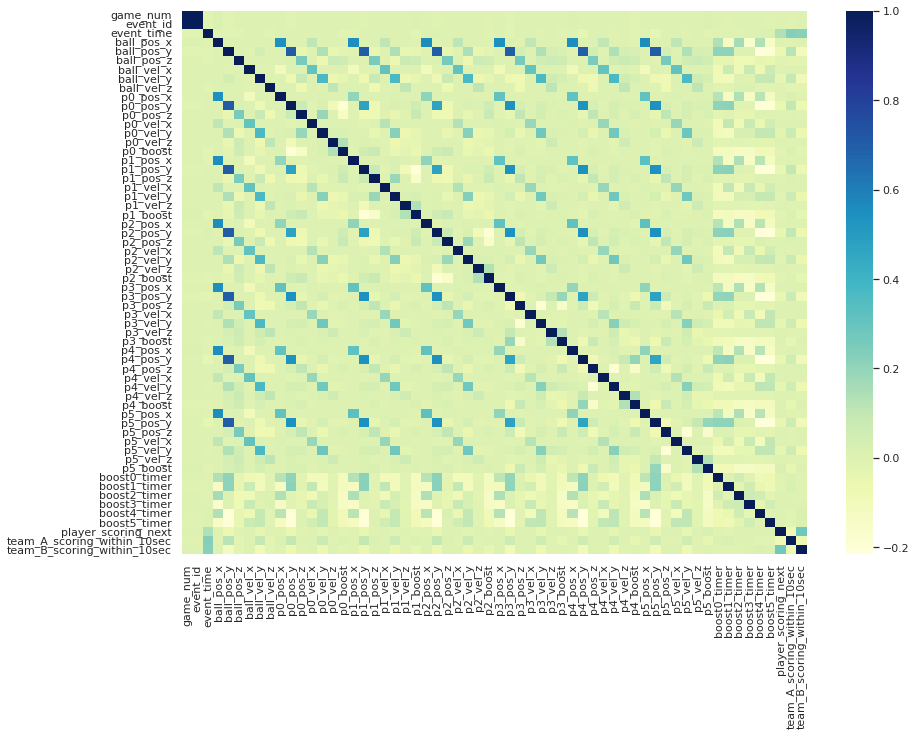

In [7]:
corr = df.corr()
sns.set(rc = {"figure.figsize": (14, 10)})

sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = "YlGnBu")

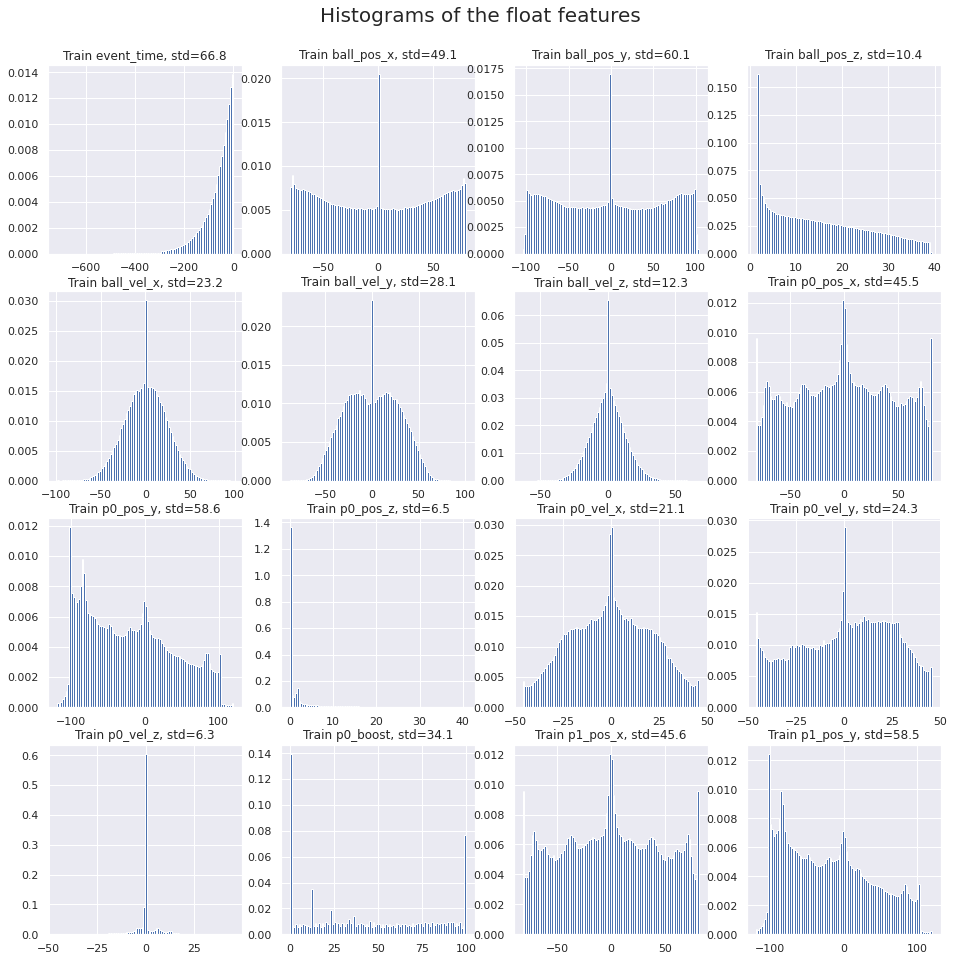

In [8]:
float_features = [f for f in df.columns if df[f].dtype == 'float64']

# Training histograms
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for f, ax in zip(float_features, axs.ravel()):
    ax.hist(df[f], density=True, bins=100)
    ax.set_title(f'Train {f}, std={df[f].std():.1f}')
plt.suptitle('Histograms of the float features', y=0.93, fontsize=20)
plt.show()

# EDA

<AxesSubplot:>

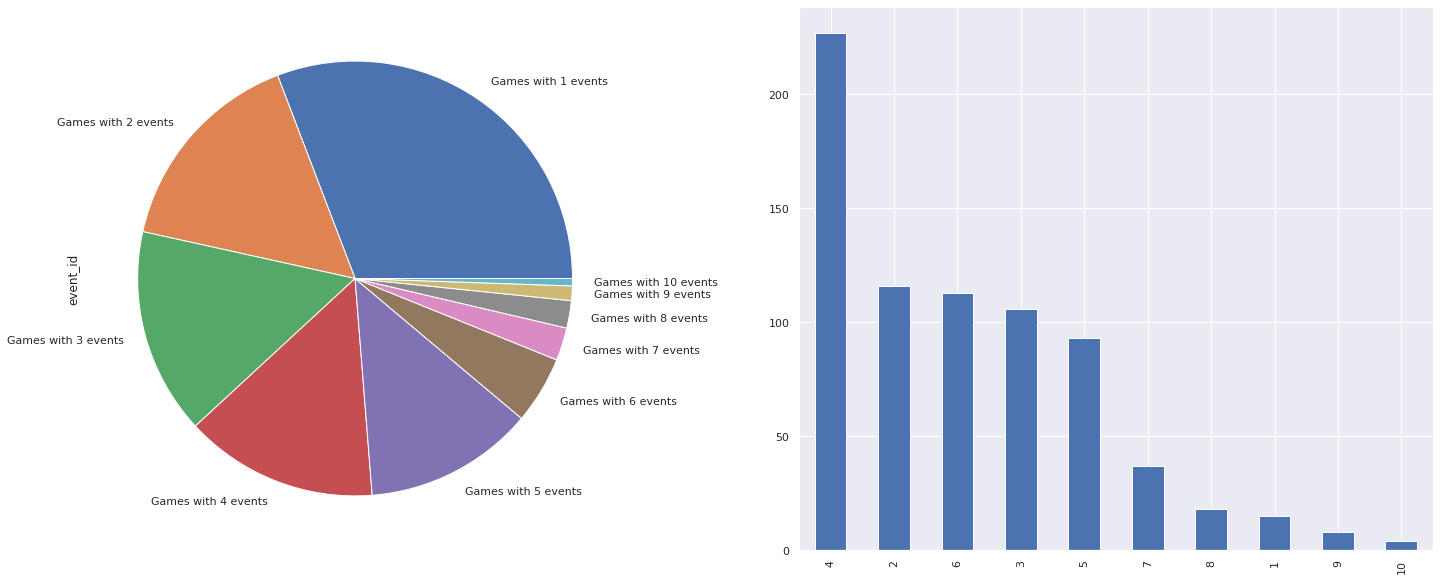

In [9]:
f, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (25, 10))
labels = [f"Games with {i+1} events" for i in range(10)]
df.groupby(['game_num'])['event_id'].nunique().value_counts().plot(kind="pie", ax=axes[0], labels=labels)
df.groupby(['game_num'])['event_id'].nunique().value_counts().plot(kind="bar", ax=axes[1])

<AxesSubplot:ylabel='Frequency'>

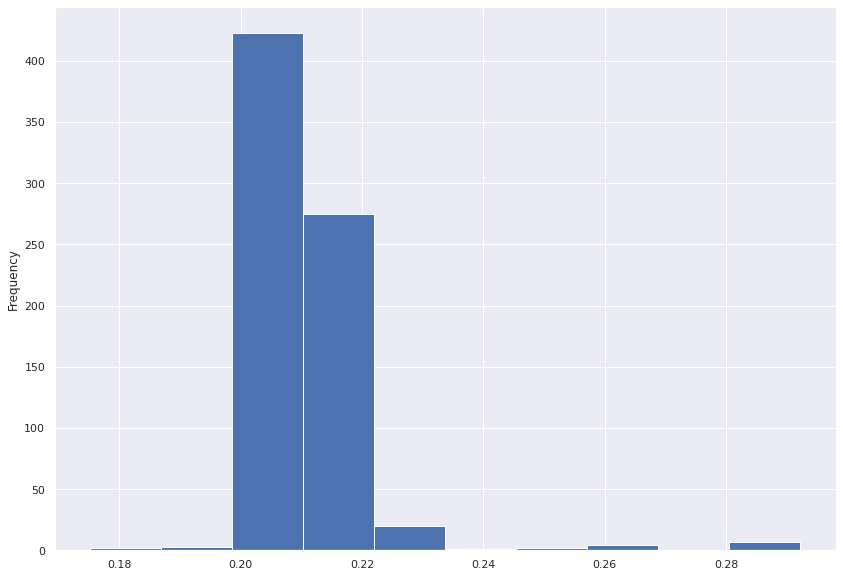

In [10]:
df['event_time_diff'] = abs(df['event_time'].shift(1).fillna(method='ffill')-df['event_time'])
average_event_time_diff_by_game = df.groupby(['game_num'])['event_time_diff'].mean()
average_event_time_diff_by_game.plot(kind="hist") 

<AxesSubplot:ylabel='team_B_scoring_within_10sec'>

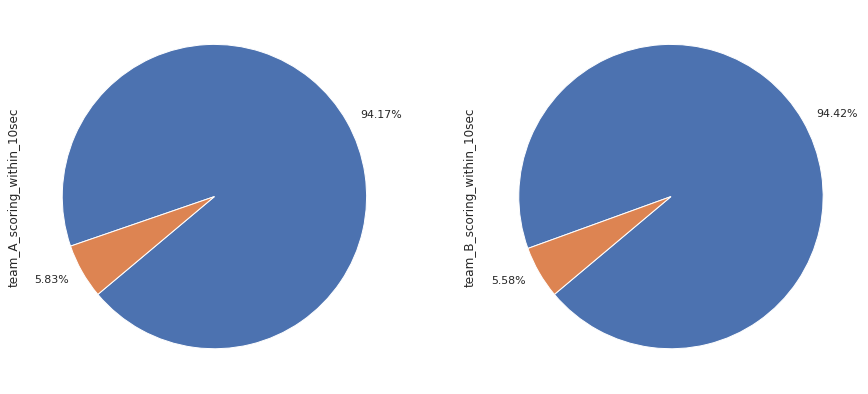

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))
labels_a = [f"{p:.2f}%" for p in df['team_A_scoring_within_10sec'].value_counts()/df['team_A_scoring_within_10sec'].value_counts().sum()*100]
labels_b = [f"{p:.2f}%" for p in df['team_B_scoring_within_10sec'].value_counts()/df['team_A_scoring_within_10sec'].value_counts().sum()*100]
df['team_A_scoring_within_10sec'].value_counts().plot(kind='pie', ax=ax1, labels=labels_a, startangle=-140)
df['team_B_scoring_within_10sec'].value_counts().plot(kind='pie', ax=ax2, labels=labels_b, startangle=-140)

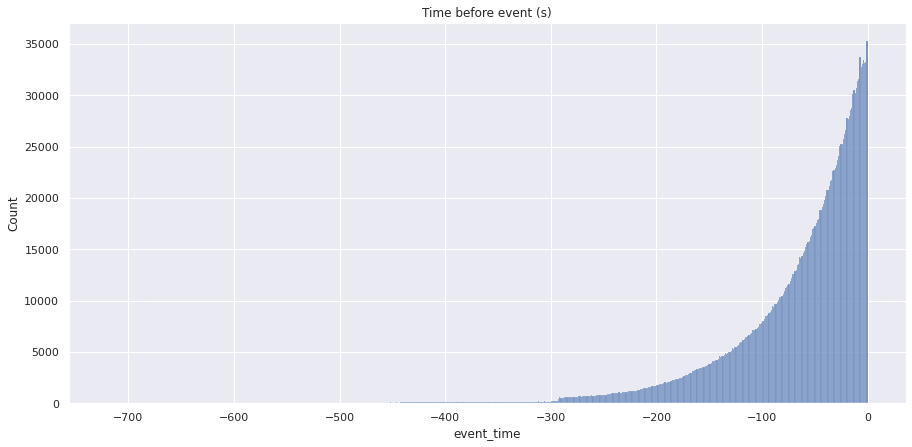

In [12]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df, x='event_time')
plt.title('Time before event (s)')
plt.show()

# features

In [13]:
features = [
    'ball_pos_x', 'ball_pos_y','ball_pos_z', 'ball_vel_x', 'ball_vel_y', 'ball_vel_z', 
    'p0_pos_x', 'p0_pos_y', 'p0_pos_z', 'p0_vel_x', 'p0_vel_y', 'p0_vel_z', 'p0_boost', 'p0_na',
    'p1_pos_x', 'p1_pos_y', 'p1_pos_z', 'p1_vel_x', 'p1_vel_y', 'p1_vel_z', 'p1_boost', 'p1_na',
    'p2_pos_x', 'p2_pos_y', 'p2_pos_z', 'p2_vel_x', 'p2_vel_y', 'p2_vel_z', 'p2_boost', 'p2_na',
    'p3_pos_x', 'p3_pos_y', 'p3_pos_z', 'p3_vel_x', 'p3_vel_y', 'p3_vel_z', 'p3_boost', 'p3_na',
    'p4_pos_x', 'p4_pos_y', 'p4_pos_z', 'p4_vel_x', 'p4_vel_y', 'p4_vel_z', 'p4_boost', 'p4_na',
    'p5_pos_x', 'p5_pos_y', 'p5_pos_z', 'p5_vel_x', 'p5_vel_y', 'p5_vel_z', 'p5_boost', 'p5_na',
    'boost0_timer', 'boost1_timer', 
    'boost2_timer', 'boost3_timer',
    'boost4_timer', 'boost5_timer']

features_x_pos = [pos for pos, feature in enumerate(features) if feature.endswith('_x')]
features_y_pos = [pos for pos, feature in enumerate(features) if feature.endswith('_y')]

targets = [
    'team_A_scoring_within_10sec',
    'team_B_scoring_within_10sec']

In [14]:
%%time
DEBUG = False
input_path = Path('../input/fast-loading-high-compression-with-feather/feather_data')

def fe(x):
    # indicators for respawns...
    x['p0_na'] = x['p0_pos_x'].isna().astype('int8')
    x['p1_na'] = x['p1_pos_x'].isna().astype('int8')
    x['p2_na'] = x['p2_pos_x'].isna().astype('int8')
    x['p3_na'] = x['p3_pos_x'].isna().astype('int8')
    x['p4_na'] = x['p4_pos_x'].isna().astype('int8')
    x['p5_na'] = x['p5_pos_x'].isna().astype('int8')
    for feature in features:
        if feature.endswith('_na'):
            continue
        # this is just scaling the features to something reasonable
        # it might make sense to apply a transformation to the z-dimension.
        if feature.endswith('_x'):
            x[feature] = (x[feature] / 82).fillna(0).astype('float16')
        if feature.endswith('_y'):
            x[feature] = (x[feature] / 120).fillna(0).astype('float16')
        if feature.endswith('_z'):
            x[feature] = (x[feature] / 40).fillna(0).astype('float16')
        if feature.endswith('_boost'):
            x[feature] = (x[feature] / 100).fillna(0).astype('float16')
        if feature.endswith('_timer'):
            x[feature] = (-x[feature] / 100).astype('float16')
    return x

def read_train():
    dfs = []
    for i in range(10):
        dfs.append(fe(pd.read_feather(input_path / f'train_{i}_compressed.ftr')))
    result = pd.concat(dfs)
    if DEBUG:
        result = result.sample(frac=0.05)
    return result

def read_test():
    return fe(pd.read_feather(input_path / 'test_compressed.ftr'))

df_train = read_train()
gc.collect()

print(f'Train Rows = {len(df_train):,}  ' 
      f'Memory Usage = {df_train.memory_usage(deep=True).sum() / (1024 * 1024):4.1f} Mb'
     '\n')

Train Rows = 21,198,036  Memory Usage = 2708.9 Mb

CPU times: user 36.9 s, sys: 9.51 s, total: 46.4 s
Wall time: 55.5 s


In [15]:
df1 = pd.read_csv("../input/tps-2022-10-fastai-with-multistart-and-tta/model_fastai_multistart_tta.csv") # 0.19443

In [16]:
scores = [0.19443, 0.19674, 0.19778, 0.19895]

In [17]:
(1 - scores[0]) / (len(scores) - sum(scores))

0.25079231655303386

In [18]:
#result_df = pd.DataFrame()
#result_df["id"] = df1.id
#result_df["team_A_scoring_within_10sec"] = df1.team_A_scoring_within_10sec * ((1 - scores[0]) / (len(scores) - sum(scores))) + df2.team_A_scoring_within_10sec * ((1 - scores[1]) / (len(scores) - sum(scores))) + df3.team_A_scoring_within_10sec * ((1 - scores[2]) / (len(scores) - sum(scores))) + df4.team_A_scoring_within_10sec * ((1 - scores[3]) / (len(scores) - sum(scores)))
#result_df["team_B_scoring_within_10sec"] = df1.team_B_scoring_within_10sec * ((1 - scores[0]) / (len(scores) - sum(scores))) + df2.team_B_scoring_within_10sec * ((1 - scores[1]) / (len(scores) - sum(scores))) + df3.team_B_scoring_within_10sec * ((1 - scores[2]) / (len(scores) - sum(scores))) + df4.team_B_scoring_within_10sec * ((1 - scores[3]) / (len(scores) - sum(scores)))

In [19]:
df1.head()

,id,team_A_scoring_within_10sec,team_B_scoring_within_10sec
0,0,0.019663,0.052205
1,1,0.002719,0.167825
2,2,0.022832,0.085306
3,3,0.055432,0.009077
4,4,0.014265,0.048222


# Submission

In [20]:
df1.to_csv("submission.csv", index=False)

# Thank you for reading!

# Please let me know if you have any questions and I look forward to any suggestions 🙂